### Seth Cattanach and Tommy Clare

#### Using survival analysis to analyze sepsis mortality as a function of length of stay and various demographic features
#### CSE-40817 Fall 2018
#### University of Notre Dame

In [62]:
import pandas as pd
import numpy as np
import scipy as sp
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import patsy 
import math
from lifelines import KaplanMeierFitter
import ipywidgets as widgets
from IPython.display import clear_output
from lifelines.plotting import plot_lifetimes

In [63]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
#Add some formatting options so you can always see your data
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('max_colwidth', 100000)

In [64]:
sepsis_data = pd.read_csv("./sepsis3-df-no-exclusions.csv")
sepsis_data.head()

,subject_id,icustay_id,hadm_id,excluded,intime,outtime,dbsource,suspected_infection_time_poe,suspected_infection_time_poe_days,specimen_poe,positiveculture_poe,antibiotic_time_poe,blood_culture_time,blood_culture_positive,age,gender,is_male,ethnicity,race_white,race_black,race_hispanic,race_other,metastatic_cancer,diabetes,height,weight,bmi,first_service,hospital_expire_flag,thirtyday_expire_flag,icu_los,hosp_los,sepsis_angus,sepsis_martin,sepsis_explicit,septic_shock_explicit,severe_sepsis_explicit,sepsis_nqf,sepsis_cdc,sepsis_cdc_simple,elixhauser_hospital,vent,sofa,lods,sirs,qsofa,qsofa_sysbp_score,qsofa_gcs_score,qsofa_resprate_score,exclusion_secondarystay,exclusion_nonadult,exclusion_csurg,exclusion_carevue,exclusion_early_suspicion,exclusion_late_suspicion,exclusion_bad_data,composite_outcome,blood culture,suspicion_poe,abx_poe,sepsis-3,sofa>=2
0,55973,200001,152234,1,2181-11-25 19:06:12,2181-11-28 20:59:25,metavision,2181-11-18 11:10:00,7.330694,BLOOD CULTURE,0.0,2181-11-18 00:00:00,2181-11-24 00:12:00,1,61.0499,F,0,ASIAN - ASIAN INDIAN,0,0,0,1,0,1,170.18,61.0,21.062640,MED,0,0,3.0786,15.901389,0,0,0,0,0,0,0,0,3,0,6,7,3,2,1.0,0.0,1.0,1,0,0,0,1,0,0,1,True,True,True,1,1
1,27513,200003,163557,1,2199-08-02 19:50:04,2199-08-08 17:09:18,carevue,2199-08-02 21:02:00,-0.049954,BLOOD CULTURE,1.0,2199-08-02 00:00:00,2199-08-02 21:02:00,1,48.2940,M,1,WHITE,1,0,0,0,0,0,177.80,77.0,24.357192,SURG,0,0,5.8884,20.081944,1,1,0,0,0,1,1,1,0,1,6,3,4,2,1.0,0.0,1.0,0,0,0,1,0,0,0,1,True,True,True,1,1
2,10950,200006,189514,1,2159-09-03 11:28:14,2159-09-04 19:08:10,carevue,NaN,NaN,NaN,NaN,NaN,2159-09-03 09:00:00,1,54.0710,M,1,OTHER,0,0,0,1,0,1,165.10,82.4,30.229646,MED,0,0,1.3194,2.304167,0,0,0,0,0,0,0,0,-5,1,1,2,2,2,1.0,0.0,1.0,1,0,0,1,0,0,0,0,True,False,False,0,0
3,20707,200007,129310,1,2109-02-17 10:03:37,2109-02-18 17:03:12,carevue,NaN,NaN,NaN,NaN,NaN,NaN,0,43.3439,M,1,WHITE,1,0,0,0,0,0,177.80,126.0,39.857223,CMED,0,0,1.2914,3.239583,0,0,0,0,0,0,0,0,0,0,1,2,2,2,1.0,0.0,1.0,0,0,0,1,0,0,0,0,False,False,False,0,0
4,29904,200009,129607,1,2189-11-30 10:34:32,2189-12-02 14:17:37,carevue,NaN,NaN,NaN,NaN,2189-11-30 00:00:00,NaN,0,47.5548,F,0,WHITE,1,0,0,0,0,0,161.29,87.2,33.519814,CSURG,0,0,2.1549,6.177083,0,0,0,0,0,0,0,0,-4,1,3,4,4,2,1.0,0.0,1.0,0,0,1,1,0,0,0,0,False,False,True,0,1


In [65]:
sepsis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 62 columns):
subject_id                           61532 non-null int64
icustay_id                           61532 non-null int64
hadm_id                              61532 non-null int64
excluded                             61532 non-null int64
intime                               61532 non-null object
outtime                              61522 non-null object
dbsource                             61532 non-null object
suspected_infection_time_poe         35389 non-null object
suspected_infection_time_poe_days    35389 non-null float64
specimen_poe                         35389 non-null object
positiveculture_poe                  35389 non-null float64
antibiotic_time_poe                  41056 non-null object
blood_culture_time                   46140 non-null object
blood_culture_positive               61532 non-null int64
age                                  61532 non-null float64
gender  

## Preprocessing: removing patients with metastatic cancer and diabetes + removing patients with null factors in what we're analyzing

In [66]:
sepsis_data.intime = pd.to_datetime(sepsis_data.intime)
sepsis_data.outtime = pd.to_datetime(sepsis_data.outtime)

### Preprocessing pt 1
# Remove patients with metastatic cancer and diabetes
sepsis_data_rm = sepsis_data[(sepsis_data["diabetes"] == 0) & (sepsis_data["metastatic_cancer"] == 0)]

### Preprocessing pt 2
# Remove patients with null values in factors we are analyzing.
sepsis_mod = sepsis_data_rm.dropna(subset=["age","gender","weight","race_white","race_black","race_hispanic","race_other"]) # Could change later. 

### Preprocessing pt 3
# Set patients with null values in suspected_infection_time_poe_days to 0. This means they were diagnosed before
# coming into the hospital, so we assume they were diagnosed as soon as they come in.

sepsis_mod = sepsis_mod.replace({'suspected_infection_time_poe_days': np.nan}, value=0.0)
display(sepsis_mod.head())

### Preprocessing pt 4 
# Set patients with negative values of suspected infection time to 0.
sepsis_mod.loc[~(sepsis_mod['suspected_infection_time_poe_days'] > 0), 'suspected_infection_time_poe_days']= 0


#print(sepsis_mod[sepsis_mod['race_white']==1].shape) ====> 24013
#print(sepsis_mod[sepsis_mod['race_black']==1].shape) # ====> 2611
#print(sepsis_mod[sepsis_mod['race_hispanic']==1].shape) # ====> 1008
#print(sepsis_mod[sepsis_mod['race_other']==1].shape) # ====> 5230
# print(sepsis_mod.columns)

,subject_id,icustay_id,hadm_id,excluded,intime,outtime,dbsource,suspected_infection_time_poe,suspected_infection_time_poe_days,specimen_poe,positiveculture_poe,antibiotic_time_poe,blood_culture_time,blood_culture_positive,age,gender,is_male,ethnicity,race_white,race_black,race_hispanic,race_other,metastatic_cancer,diabetes,height,weight,bmi,first_service,hospital_expire_flag,thirtyday_expire_flag,icu_los,hosp_los,sepsis_angus,sepsis_martin,sepsis_explicit,septic_shock_explicit,severe_sepsis_explicit,sepsis_nqf,sepsis_cdc,sepsis_cdc_simple,elixhauser_hospital,vent,sofa,lods,sirs,qsofa,qsofa_sysbp_score,qsofa_gcs_score,qsofa_resprate_score,exclusion_secondarystay,exclusion_nonadult,exclusion_csurg,exclusion_carevue,exclusion_early_suspicion,exclusion_late_suspicion,exclusion_bad_data,composite_outcome,blood culture,suspicion_poe,abx_poe,sepsis-3,sofa>=2
1,27513,200003,163557,1,2199-08-02 19:50:04,2199-08-08 17:09:18,carevue,2199-08-02 21:02:00,-0.049954,BLOOD CULTURE,1.0,2199-08-02 00:00:00,2199-08-02 21:02:00,1,48.2940,M,1,WHITE,1,0,0,0,0,0,177.80,77.0,24.357192,SURG,0,0,5.8884,20.081944,1,1,0,0,0,1,1,1,0,1,6,3,4,2,1.0,0.0,1.0,0,0,0,1,0,0,0,1,True,True,True,1,1
3,20707,200007,129310,1,2109-02-17 10:03:37,2109-02-18 17:03:12,carevue,NaN,0.000000,NaN,NaN,NaN,NaN,0,43.3439,M,1,WHITE,1,0,0,0,0,0,177.80,126.0,39.857223,CMED,0,0,1.2914,3.239583,0,0,0,0,0,0,0,0,0,0,1,2,2,2,1.0,0.0,1.0,0,0,0,1,0,0,0,0,False,False,False,0,0
4,29904,200009,129607,1,2189-11-30 10:34:32,2189-12-02 14:17:37,carevue,NaN,0.000000,NaN,NaN,2189-11-30 00:00:00,NaN,0,47.5548,F,0,WHITE,1,0,0,0,0,0,161.29,87.2,33.519814,CSURG,0,0,2.1549,6.177083,0,0,0,0,0,0,0,0,-4,1,3,4,4,2,1.0,0.0,1.0,0,0,1,1,0,0,0,0,False,False,True,0,1
6,93535,200011,121562,1,2188-08-06 01:39:24,2188-08-07 16:50:53,metavision,2188-08-05 21:41:00,0.165556,URINE,1.0,2188-08-05 00:00:00,2188-08-05 21:41:00,1,84.2318,F,0,WHITE,1,0,0,0,0,0,147.32,101.4,46.721259,MED,0,0,1.6330,1.847917,0,0,0,0,0,0,1,1,8,1,3,4,1,1,0.0,0.0,1.0,1,0,0,0,0,0,0,0,True,True,True,1,1
7,28448,200012,177527,1,2153-12-23 05:12:55,2153-12-23 15:55:54,carevue,2153-12-23 00:30:00,0.196470,BLOOD CULTURE,0.0,2153-12-23 00:00:00,2153-12-23 00:30:00,0,32.9891,F,0,ASIAN,0,0,0,1,0,0,NaN,51.2,NaN,MED,0,0,0.4465,0.425694,0,1,0,0,0,1,0,0,0,0,1,1,3,2,1.0,0.0,1.0,0,0,0,1,0,0,0,0,True,True,True,0,0


In [67]:
time_baseline = sepsis_mod.sort_values(by='intime').intime.iloc[0]

sepsis_mod['corrected_intime'] = (sepsis_mod.intime - time_baseline).dt.total_seconds()
sepsis_mod['corrected_outtime'] = (sepsis_mod.outtime - time_baseline).dt.total_seconds()
sepsis_mod['stay_duration_sec'] = (sepsis_mod.corrected_outtime - sepsis_mod.corrected_intime)
sepsis_mod['stay_duration_days'] = sepsis_mod.stay_duration_sec/(3600*24)

### For the calculation of TTE for patients, factoring in how long it took to discover they had sepsis.

sepsis_mod['known_sepsis_time'] = sepsis_mod.stay_duration_days - sepsis_mod.suspected_infection_time_poe_days 
sepsis_mod.loc[~(sepsis_mod['known_sepsis_time'] > 0), 'known_sepsis_time']= 0 # Sometimes will be negative; adjust to 0.


#sepsis_mod[['suspected_infection_time_poe_days','stay_duration_days','known_sepsis_time']]
#sepsis_mod = sepsis_mod.sort_values(by='corrected_intime')

In [68]:


def qth_survival_time(q, survival_function, cdf=False):
    """
    Expects a Pandas series, returns the time when the qth probability is reached.
    """
    if cdf:
        if survival_function.iloc[0] > q:
            return np.inf
        v = (survival_function <= q).idxmin(0)
    else:
        if survival_function.iloc[-1] > q:
            return np.inf
        v = (survival_function <= q).idxmax(0)
        
    return(v)



In [69]:

# Do preprocessing for what will become different data subsets.

sepsis_mod_black = sepsis_mod[sepsis_mod['race_black']==1]
sepsis_mod_hispanic = sepsis_mod[sepsis_mod['race_hispanic']==1]
sepsis_mod_white = sepsis_mod[sepsis_mod['race_white']==1]
sepsis_mod_other = sepsis_mod[sepsis_mod['race_other']==1]

sepsis_mod_any_male = sepsis_mod[sepsis_mod['gender']=="M"]
sepsis_mod_any_female = sepsis_mod[sepsis_mod['gender']=='F']

sepsis_mod_black_male = sepsis_mod[(sepsis_mod['race_black']==1) & (sepsis_mod['gender']=='M')]
sepsis_mod_black_female = sepsis_mod[(sepsis_mod['race_black']==1) & (sepsis_mod['gender']=='F')]
sepsis_mod_hispanic_male  = sepsis_mod[(sepsis_mod['race_hispanic']==1) & (sepsis_mod['gender']=='M')]
sepsis_mod_hispanic_female = sepsis_mod[(sepsis_mod['race_hispanic']==1) & (sepsis_mod['gender']=='F')]
sepsis_mod_white_male = sepsis_mod[(sepsis_mod['race_white']==1) & (sepsis_mod['gender']=='M')]
sepsis_mod_white_female = sepsis_mod[(sepsis_mod['race_white']==1) & (sepsis_mod['gender']=='F')]
sepsis_mod_other_male = sepsis_mod[(sepsis_mod['race_other']==1) & (sepsis_mod['gender']=='M')]
sepsis_mod_other_female = sepsis_mod[(sepsis_mod['race_other']==1) & (sepsis_mod['gender']=='F')]

sepsis_mod_normal = sepsis_mod


# Initialize what will eventually become dropdown menus (make global to allow slider values to write back and preserve)

global race 
race = "Any"
global age 
age = 25
global weight 
weight = 100
global gender 
gender = "Any"


def changeDiagram(race, age, weight, gender, diagnosis=True):
    #print("calling changeDiagram with race = {}, age = {}, weight = {}, gender = {}".format(race, age, weight, gender))
    
    if race == "African American" and gender == "Male":   
        mod_adjustment = sepsis_mod_black_male[(sepsis_mod_black_male['age'] >= age) & (sepsis_mod_black_male['weight'] >= weight)]        
    elif race == "African American" and gender == "Female":
        mod_adjustment = sepsis_mod_black_female[(sepsis_mod_black_female['age'] >= age) & (sepsis_mod_black_female['weight'] >= weight)]
    elif race == "African American" and gender == "Any":
        mod_adjustment = sepsis_mod_black[(sepsis_mod_black['age'] >= age) & (sepsis_mod_black['weight'] >= weight)]
        
    elif race == "Hispanic" and gender == "Male":
        mod_adjustment = sepsis_mod_hispanic_male[(sepsis_mod_hispanic_male['age'] >= age) & (sepsis_mod_hispanic_male['weight'] >= weight)]
    elif race == "Hispanic" and gender == "Female":
        mod_adjustment = sepsis_mod_hispanic_female[(sepsis_mod_hispanic_female['age'] >= age) & (sepsis_mod_hispanic_female['weight'] >= weight)]
    elif race == "Hispanic" and gender == "Any":
        mod_adjustment = sepsis_mod_hispanic[(sepsis_mod_hispanic['age'] >= age) & (sepsis_mod_hispanic['weight'] >= weight)]
        
    elif race == "White" and gender == "Male":
        mod_adjustment = sepsis_mod_white_male[(sepsis_mod_white_male['age'] >= age) & (sepsis_mod_white_male['weight'] >= weight)]
    elif race == "White" and gender == "Female":
        mod_adjustment = sepsis_mod_white_female[(sepsis_mod_white_female['age'] >= age) & (sepsis_mod_white_female['weight'] >= weight)]
    elif race == "White" and gender == "Any":
        mod_adjustment = sepsis_mod_white[(sepsis_mod_white['age'] >= age) & (sepsis_mod_white['weight'] >= weight)]       
        
    elif race == "Other" and gender == "Male":
        mod_adjustment = sepsis_mod_other_male[(sepsis_mod_other_male['age'] >= age) & (sepsis_mod_other_male['weight'] >= weight)]
    elif race == "Other" and gender == "Female":
        mod_adjustment = sepsis_mod_other_female[(sepsis_mod_other_female['age'] >= age) & (sepsis_mod_other_female['weight'] >= weight)]
    elif race == "Other" and gender == "Any":
        mod_adjustment = sepsis_mod_other[(sepsis_mod_other['age'] >= age) & (sepsis_mod_other['weight'] >= weight)]
        
    elif race == "Any" and gender == "Male":
        mod_adjustment = sepsis_mod_any_male[(sepsis_mod_any_male['age'] >= age) & (sepsis_mod_any_male['weight'] >= weight)]
    elif race == "Any" and gender == "Female":
        mod_adjustment = sepsis_mod_any_female[(sepsis_mod_any_female['age'] >= age) & (sepsis_mod_any_female['weight'] >= weight)]
    elif race == "Any" and gender == "Any":
        mod_adjustment = sepsis_mod_normal[(sepsis_mod_normal['age'] >= age) & (sepsis_mod_normal['weight'] >= weight)]
        

    
    TTE = mod_adjustment['stay_duration_days']
    TTE_diagnosis = mod_adjustment['known_sepsis_time']
    
    EventFlg = mod_adjustment['hospital_expire_flag']
    
    kmf = KaplanMeierFitter()
    kmfDiagnosis = KaplanMeierFitter()
    
    
    
    if not diagnosis:
        return kmf.fit(TTE, event_observed=EventFlg,label='Full Data')
    else:
        return kmfDiagnosis.fit(TTE_diagnosis, event_observed=EventFlg,label='Full Data')
    

### PLOT LIFELINES NOT WORKING!!! WTF

In [70]:


#This function takes the following paramaters:
#plot_lifetimes(Time-To-Event-Series, event_observed=Event-Observed-Series)
# plt.xlabel("time")
# plt.title("Timespans of patient mortality")
#plot_lifetimes(TTE, event_observed=EventFlg) <-- THIS THROWS A KEY = 0 ERROR :/

In [71]:
%matplotlib inline


# Slider Demo


Using the slider widget to control visual properties of your plot.

In this example, a slider is used to choose the frequency of a sine
wave. You can control many continuously-varying properties of your plot in
this way.



In [72]:
r = widgets.Dropdown(
    options=['Any','White', 'African American', 'Hispanic', 'Other'],
    value='Any',
    description='Race:',
)


a = widgets.IntSlider(
    value=25,
    min=10,
    max=80,
    step=1,
    description='Age:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


w = widgets.IntSlider(
    value = 100,
    min = 50, 
    max = 300,
    step = 1,
    description="Weight:",
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
      

)


g = widgets.Dropdown(
    options=['Any','Male', 'Female'],
    value='Any',
    description='Gender:',
)


In [73]:
def on_change_race(change):
    if change['type'] == 'change' and change['name'] == 'value':
        race = change['new']
        clear_output()
        display(r,a,w,g)
        age = a.value
        weight = w.value
        gender = g.value
        new_plot = changeDiagram(race,age,weight,gender, False)
        new_plot_diagnosis = changeDiagram(race,age,weight,gender, True)
        print("""A patient with these conditions is 50% likely to survive after {} days.""".format(qth_survival_time(.5,new_plot.survival_function_[new_plot.survival_function_.columns[0]])))
        print("After adjusting for late diagnosis times, the patient with these conditions would have been 50% likely to survive after {} days.".format(qth_survival_time(.5,new_plot_diagnosis.survival_function_[new_plot.survival_function_.columns[0]])))
        new_plot.plot()
        new_plot_diagnosis.plot()
        print(race)
        
        
        # Generate a new Kaplan Meier curve here. 

r.observe(on_change_race)

#display(r)


def on_change_age(change):
    if change['type'] == 'change' and change['name'] == 'value':
        age = change['new']
        clear_output()
        display(r,a,w,g)
        race = r.value
        weight = w.value
        gender = g.value
        new_plot = changeDiagram(race,age,weight,gender, False)
        new_plot_diagnosis = changeDiagram(race,age,weight,gender, True)
        print("""A patient with these conditions is 50% likely to survive after {} days.""".format(qth_survival_time(.5,new_plot.survival_function_[new_plot.survival_function_.columns[0]])))   
        print("After adjusting for late diagnosis times, the patient with these conditions would have been 50% likely to survive after {} days.".format(qth_survival_time(.5,new_plot_diagnosis.survival_function_[new_plot.survival_function_.columns[0]])))
        new_plot.plot()
        new_plot_diagnosis.plot()
        print(age)
        # Generate a new Kaplan Meier curve here. 

a.observe(on_change_age)


def on_change_weight(change):
    if change['type'] == 'change' and change['name'] == 'value':
        weight = change['new']
        clear_output()
        display(r,a,w,g)
        race = r.value
        weight = w.value
        age = a.value
        new_plot = changeDiagram(race,age,weight,gender, False)
        new_plot_diagnosis = changeDiagram(race,age,weight,gender, True)
        print("""A patient with these conditions is 50% likely to survive after {} days.""".format(qth_survival_time(.5,new_plot.survival_function_[new_plot.survival_function_.columns[0]])))
        print("After adjusting for late diagnosis times, the patient with these conditions would have been 50% likely to survive after {} days.".format(qth_survival_time(.5,new_plot_diagnosis.survival_function_[new_plot.survival_function_.columns[0]])))
        new_plot.plot()
        new_plot_diagnosis.plot()
        print(weight)
        
w.observe(on_change_weight)


def on_change_gender(change):
    if change['type'] == 'change' and change['name'] == 'value':
        gender = change['new']
        clear_output()
        display(r,a,w,g)
        race = r.value
        age = a.value
        weight = w.value
        new_plot = changeDiagram(race,age,weight,gender, False)
        new_plot_diagnosis = changeDiagram(race,age,weight,gender, True)
        
        print("""A patient with these conditions is 50% likely to survive after {} days.""".format(qth_survival_time(.5,new_plot.survival_function_[new_plot.survival_function_.columns[0]])))
        
        print("After adjusting for late diagnosis times, the patient with these conditions would have been 50% likely to survive after {} days.".format(qth_survival_time(.5,new_plot_diagnosis.survival_function_[new_plot.survival_function_.columns[0]])))
        
        new_plot.plot()
        new_plot_diagnosis.plot()
        print(gender)

g.observe(on_change_gender)




        
display(r,a, w, g)

new_plot = changeDiagram(race,age,weight,gender, False)
new_plot_diagnosis = changeDiagram(race,age,weight,gender, True)



Dropdown(description='Race:', options=('Any', 'White', 'African American', 'Hispanic', 'Other'), value='Any')

IntSlider(value=25, continuous_update=False, description='Age:', max=80, min=10)

IntSlider(value=100, continuous_update=False, description='Weight:', max=300, min=50)

Dropdown(description='Gender:', options=('Any', 'Male', 'Female'), value='Any')

## A more quantitative approach: Cox Proportional Hazard Analysis

Cox Proportional Hazard Analysis, CPH, allows us to analyze the significance of our chosen features with greater statistical detail. Below, we'll use this method to obtain the hazard model coefficients, which indicate how much the hazard function (of the outcome, hospital_expire_flag) changes with respect to a reference category (for continuous features, this is x --> x+1 and for categorical features, this is with respect to a default reference)

#### First, we'll use CPH to analyze sepsis mortality with respect to the "stay_duration_days" time until event column
This is our "baseline" - we'll later repeat this process with the "known_sepsis_time" TTE column to see if there's a significant difference between sepsis mortality odds when survival analysis is based on when a patient is known to have sepsis

In [74]:
# "roll up" the ethnicity column into four groups: race_white, race_black, race_hispanic, race_other
sepsis_cph = sepsis_mod
sepsis_cph.ethnicity = sepsis_cph.ethnicity.replace(regex={r'^HISP.*':'HISPANIC', r'^WHITE.*':'WHITE', r'^BLACK.*':'BLACK', r'^UNKNOWN.*':'OTHER', r'^OTHER.*':'OTHER', r'^ASIAN.*':'ASIAN', r'^SOUTH.*':'WHITE', r'^MULTI.*':'OTHER', r'^PAT.*':'OTHER', r'^NATIVE.*':'OTHER', r'^AMER.*':'OTHER', r'^MID.*':'OTHER', r'^CAR.*':'OTHER', r'^UN.*':'OTHER', r'^PORT.*':'OTHER'})


In [75]:
# test filtering
#sepsis_cph[sepsis_cph['ethnicity']=='ASIAN'].shape
#sepsis_cph.ethnicity

In [76]:
# prepare to create and fit CPH model (note: ethnicity reference category is set to "WHITE")
# this is for the "unadjusted" time-to-event column

import patsy
from lifelines import CoxPHFitter
formula = "age + is_male + weight + C(ethnicity, Treatment(reference='WHITE')) + hospital_expire_flag + stay_duration_days"
#formula = 'age + is_male + weight + race_other + race_white + race_black + race_hispanic + hospital_expire_flag + stay_duration_days'
X = patsy.dmatrix(formula, sepsis_cph, return_type='dataframe')
del X['Intercept']
X = X.dropna()

In [77]:
# create and fit the CPH model

cph = CoxPHFitter()
cph.fit(X, duration_col='stay_duration_days', event_col='hospital_expire_flag', show_progress=True)

Iteration 1: norm_delta = 0.36192, step_size = 0.95000, ll = -35035.83832, seconds_since_start = 0.7
Iteration 2: norm_delta = 0.05823, step_size = 0.95000, ll = -34722.44091, seconds_since_start = 1.4
Iteration 3: norm_delta = 0.00430, step_size = 0.95000, ll = -34716.09595, seconds_since_start = 2.0
Iteration 4: norm_delta = 0.00022, step_size = 0.95000, ll = -34716.06400, seconds_since_start = 2.7
Iteration 5: norm_delta = 0.00001, step_size = 0.95000, ll = -34716.06392, seconds_since_start = 3.3
Iteration 6: norm_delta = 0.00000, step_size = 0.95000, ll = -34716.06392, seconds_since_start = 3.9
Convergence completed after 6 iterations.


<lifelines.CoxPHFitter: fitted with 32862 observations, 28987 censored>

In [78]:
# print results
cph.print_summary()

n=32862, number of events=3875

                                                          coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
C(ethnicity, Treatment(reference='WHITE'))[T.ASIAN]     0.1045     1.1102    0.1079  0.9684 0.3328     -0.1070      0.3161     
C(ethnicity, Treatment(reference='WHITE'))[T.BLACK]    -0.0691     0.9332    0.0717 -0.9638 0.3351     -0.2096      0.0714     
C(ethnicity, Treatment(reference='WHITE'))[T.HISPANIC] -0.0348     0.9658    0.1204 -0.2892 0.7724     -0.2708      0.2012     
C(ethnicity, Treatment(reference='WHITE'))[T.OTHER]     0.2841     1.3286    0.0411  6.9198 0.0000      0.2036      0.3646  ***
age                                                     0.0204     1.0206    0.0011 19.3176 0.0000      0.0184      0.0225  ***
is_male                                                 0.0469     1.0480    0.0342  1.3690 0.1710     -0.0202      0.1140     
weight                                                 -0.0063     0.993

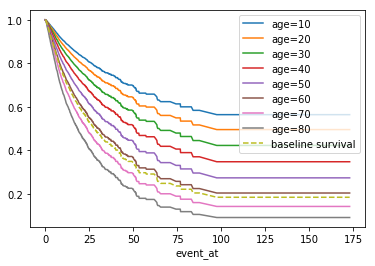

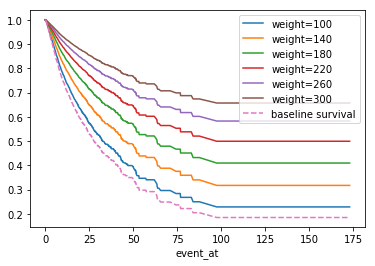

In [79]:
# Visualize our two "statistically significant" features (age and weight)
cph.plot_covariate_groups('age', [10,20,30,40,50,60,70,80])
cph.plot_covariate_groups('weight', [100, 140, 180, 220, 260, 300])

#### Now, we'll repeat this CPH analysis with the "known_sepsis_time" TTE column 
This effectively shifts the time baseline to the point in time in which sepsis is diagnosed - trying to determine how significant it is (if at all) when a patient is determined to have sepsis, in terms of mortality risk.

In [80]:
# prepare to create and fit CPH model (note: ethnicity reference category is set to "WHITE")
# this is for the "adjusted" time-to-event column (known_sepsis_time)

import patsy
from lifelines import CoxPHFitter
formula = "age + is_male + weight + C(ethnicity, Treatment(reference='WHITE')) + hospital_expire_flag + known_sepsis_time"
#formula = 'age + is_male + weight + race_other + race_white + race_black + race_hispanic + hospital_expire_flag + stay_duration_days'
X = patsy.dmatrix(formula, sepsis_cph, return_type='dataframe')
del X['Intercept']
X = X.dropna()

In [81]:
# create and fit the CPH model

cph = CoxPHFitter()
cph.fit(X, duration_col='known_sepsis_time', event_col='hospital_expire_flag', show_progress=True)

Iteration 1: norm_delta = 0.35797, step_size = 0.95000, ll = -35502.79320, seconds_since_start = 0.7
Iteration 2: norm_delta = 0.05819, step_size = 0.95000, ll = -35187.47523, seconds_since_start = 1.4
Iteration 3: norm_delta = 0.00429, step_size = 0.95000, ll = -35181.03772, seconds_since_start = 2.0
Iteration 4: norm_delta = 0.00022, step_size = 0.95000, ll = -35181.00529, seconds_since_start = 2.6
Iteration 5: norm_delta = 0.00001, step_size = 0.95000, ll = -35181.00520, seconds_since_start = 3.3
Iteration 6: norm_delta = 0.00000, step_size = 0.95000, ll = -35181.00520, seconds_since_start = 4.0
Convergence completed after 6 iterations.


<lifelines.CoxPHFitter: fitted with 32862 observations, 28987 censored>

In [82]:
# print results
cph.print_summary()

n=32862, number of events=3875

                                                          coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
C(ethnicity, Treatment(reference='WHITE'))[T.ASIAN]     0.0976     1.1026    0.1079  0.9044 0.3658     -0.1139      0.3092     
C(ethnicity, Treatment(reference='WHITE'))[T.BLACK]    -0.0888     0.9150    0.0717 -1.2388 0.2154     -0.2294      0.0517     
C(ethnicity, Treatment(reference='WHITE'))[T.HISPANIC] -0.0783     0.9247    0.1204 -0.6500 0.5157     -0.3143      0.1578     
C(ethnicity, Treatment(reference='WHITE'))[T.OTHER]     0.2597     1.2966    0.0411  6.3224 0.0000      0.1792      0.3402  ***
age                                                     0.0205     1.0207    0.0010 19.5238 0.0000      0.0184      0.0225  ***
is_male                                                 0.0403     1.0411    0.0343  1.1729 0.2408     -0.0270      0.1076     
weight                                                 -0.0061     0.993

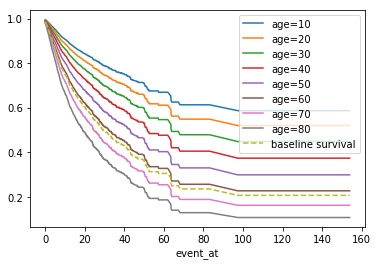

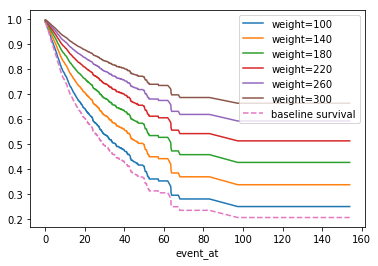

In [83]:
# Visualize our two "statistically significant" features (age and weight) and their survival analysis curves at various points:
cph.plot_covariate_groups('age', [10,20,30,40,50,60,70,80])
cph.plot_covariate_groups('weight', [100, 140, 180, 220, 260, 300])